# Build predictive model

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
 
%matplotlib inline

In [2]:
df = pd.read_csv('model_data/tci_2_2.csv')
df.shape

(13500, 60)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13500 entries, 0 to 13499
Data columns (total 60 columns):
parcel                                     13500 non-null object
House Number                               12902 non-null object
Street Name                                12577 non-null object
Category                                   13500 non-null object
Survey Date                                13500 non-null object
vacant                                     13500 non-null int64
zip                                        13204 non-null float64
propsize                                   13247 non-null float64
pclass                                     13245 non-null object
totusabl                                   13247 non-null float64
tmktval                                    13245 non-null float64
condition                                  10964 non-null object
condition_value                            10964 non-null float64
style_filtered                            

#### Count missing values as a variable

In [5]:
df['missing_values'] = df.apply(lambda x: len(x[x.isnull()]),axis=1)

In [6]:
df[['missing_values','vacant']].groupby('missing_values').agg([sum,len])

vacant      
                  sum   len
missing_values             
0                 634  3082
1                   0    14
2                 877  7679
3                   2    45
4                   8   128
5                   5   430
6                   0    54
7                  10  1135
8                   3   301
9                   2   332
10                  2    39
11                  0     6
14                  0     3
15                  1    30
16                 11   222

#### Change 'pclass' into residential/non-residential

Only use data from residential parcels in the model.

In [7]:
def fun(x):
    if x == 'Residential':
        return 1
    else:
        return 0
df['pclass_filtered'] = df['pclass'].apply(fun)

In [8]:
df[['pclass_filtered','vacant']].groupby('pclass_filtered').agg([sum,len])

vacant       
                   sum    len
pclass_filtered              
0                   44   1378
1                 1511  12122

In [9]:
df = df[df['pclass_filtered']==1]
df.shape

(12122, 62)

#### Let's look at total market value, property size, etc.

In [10]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [11]:
import seaborn as sns

In [12]:
df.head(1)

,parcel,House Number,Street Name,Category,Survey Date,vacant,zip,propsize,pclass,totusabl,...,complaint_hvac,complaint_no permit,complaint_no water,complaint_o.v.v.,complaint_plumbing,complaint_count,complaint_count_6_mon,complaint_count_3_mon,missing_values,pclass_filtered
0,121-31-003,2427,WOODHILL RD,Occupied Structure,2014-03-18,0,44104,8155,Residential,0,...,0,0,0,0,0,0,0,0,8,1


AttributeError: max must be larger than min in range parameter.

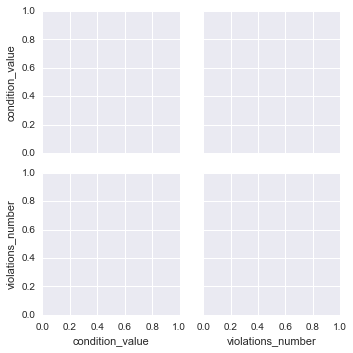

In [14]:
sns.pairplot(df, vars=['condition_value','violations_number'], hue='vacant')

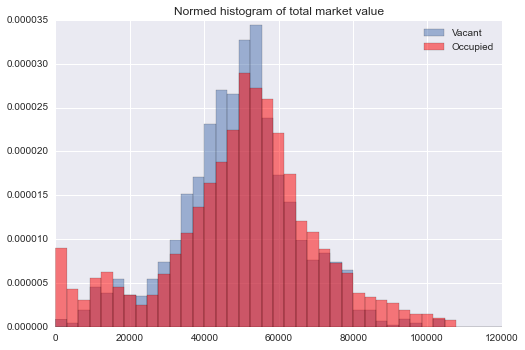

In [15]:
b = np.linspace(0, 120000, 40)
plt.hist(df.loc[(~is_outlier(df.tmktval)) & (df.vacant==1),'tmktval'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(~is_outlier(df.tmktval)) & (df.vacant==0),'tmktval'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of total market value');

In [19]:
max(df.violations_number)

29.0

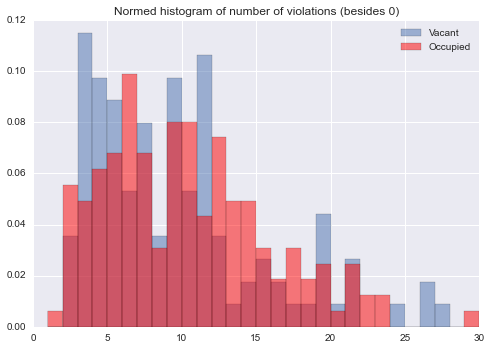

In [24]:
b = np.linspace(1, 30, 30)
plt.hist(df.loc[(df.vacant==1),'violations_number'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(df.vacant==0),'violations_number'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of number of violations (besides 0)');

In [27]:
df[['complaint_o.v.v.','vacant']].groupby('complaint_o.v.v.').agg([sum, len])

vacant       
                    sum    len
complaint_o.v.v.              
0                  1107  11516
1                   404    606

In [11]:
df[['totbldgs','vacant']].groupby('totbldgs').agg([sum, len])

vacant       
            sum    len
totbldgs              
0            15   1331
1          1486  10618
2             7     60
3             1      3

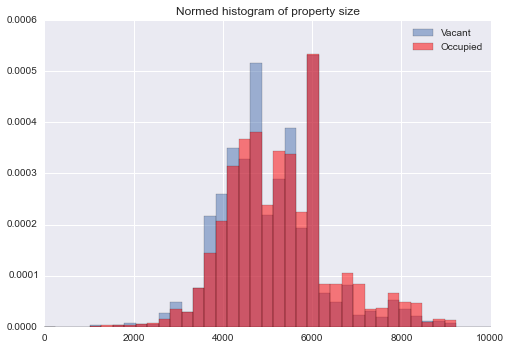

In [29]:
b = np.linspace(0, 10000, 40)
plt.hist(df.loc[(~is_outlier(df.propsize)) & (df.vacant==1),'propsize'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(~is_outlier(df.propsize)) & (df.vacant==0),'propsize'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of property size');

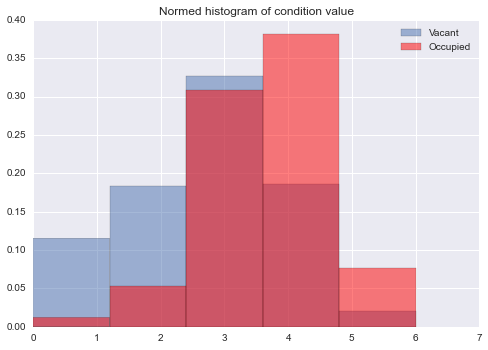

In [30]:
b = np.linspace(0, 6, 6)
plt.hist(df.loc[(~is_outlier(df.condition_value)) & (df.vacant==1),'condition_value'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(~is_outlier(df.condition_value)) & (df.vacant==0),'condition_value'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of condition value');

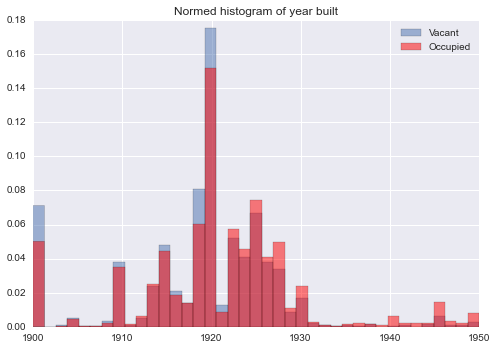

In [32]:
b = np.linspace(1900, 1950, 40)
plt.hist(df.loc[(~is_outlier(df.yrbuilt_filtered)) & (df.vacant==1),'yrbuilt_filtered'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(~is_outlier(df.yrbuilt_filtered)) & (df.vacant==0),'yrbuilt_filtered'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of year built');

In [36]:
cols = ['condition_value','totbldgs','yrbuilt_filtered','vacant', \
        'num_of_sales','quit_claim_deed','warranty_deed','limited_warranty','survivorship_deed','fiduciary_deed', \
        'county_land_bank', 'vindall_Y', 'vindall_P','task_app','task_clo', 'task_con', 'task_dem', 'task_ins', \
        'task_non','task_pro','task_sea','violations_number','violation_condemnation - garage', \
        'violation_condemnation - main structure', 'violation_exterior maintenance', 'violation_fire damage', \
        'violation_interior/exterior maintenance', 'violation_no permit', 'violation_survey', \
        'complaint_collapsing structure','complaint_complete interior/exterior', 'complaint_electrical', \
        'complaint_fire damage', 'complaint_general exterior maintenance', 'complaint_grass/weeds/bushes (occupied)', \
        'complaint_grass/weeds/bushes (vacant)', 'complaint_hvac','complaint_no permit', 'complaint_no water', \
        'complaint_o.v.v.', 'complaint_plumbing', 'complaint_count','complaint_count_6_mon', 'complaint_count_3_mon']

# 'propsize','totusabl','tmktval',

# cols = ['propsize','tmktval','condition_value','totbldgs','yrbuilt_filtered','vacant', \
#         'num_of_sales','quit_claim_deed','warranty_deed',
#         'violations_number', 'missing_values', 'ownerocc_value',\
#         'vindall_Y', 'complaint_count','complaint_count_6_mon', 'complaint_count_3_mon']

### Impute with median values

In [37]:
df.loc[df.propsize.isnull(),'propsize'] = np.median(df[df.propsize.notnull()].propsize)
df.loc[df.totusabl.isnull(),'totusabl'] = np.median(df[df.totusabl.notnull()].totusabl)
df.loc[df.tmktval.isnull(),'tmktval'] = np.median(df[df.tmktval.notnull()].tmktval)
df.loc[df.condition_value.isnull(),'condition_value'] = np.median(df[df.condition_value.notnull()].condition_value)
df.loc[df.totbldgs.isnull(),'totbldgs'] = np.median(df[df.totbldgs.notnull()].totbldgs)
df.loc[df.yrbuilt_filtered.isnull(),'yrbuilt_filtered'] = np.median(df[df.yrbuilt_filtered.notnull()].yrbuilt_filtered)
df.loc[df.ownerocc_value.isnull(),'ownerocc_value'] = np.median(df[df.ownerocc_value.notnull()].ownerocc_value)

In [38]:
df.groupby('rextwall').count()['vacant']

rextwall
Aluminum/Vinyl (r)      5635
Asbestos Shingle (r)     158
Brick                    826
Brick/Stucco (r)           8
Composite siding (r)      41
Concrete block             5
Frame (r)               3817
Frame/Brick (r)          108
Other (r)                  2
Stone                     10
Stucco (r)                27
VBR                        7
Name: vacant, dtype: int64

In [39]:
ext = pd.DataFrame(df.groupby('rextwall').count()['vacant'])
ext.columns = ['rextwall']
ext_set = set(ext[ext.rextwall > 200].index)

In [40]:
ext_set

{'Aluminum/Vinyl (r)', 'Brick', 'Frame (r)'}

In [41]:
ext_set.add('Other')

In [42]:
def check_var(x):
    if x in ext_set:
        return x
    else:
        return 'Other'
    
def check_wall(x, wall):
    if x == wall:
        return 1
    else:
        return 0
        
df['rextwall'] = df['rextwall'].apply(check_var)

for wall in ext_set:
    df['ext_'+wall.lower()] = df['rextwall'].apply(lambda x: check_wall(x, wall))

In [43]:
df.loc[df.rextwall.notnull(),['rextwall','vacant']].groupby('rextwall').agg([sum,len])

vacant      
                      sum   len
rextwall                       
Aluminum/Vinyl (r)    696  5635
Brick                  97   826
Frame (r)             635  3817
Other                  83  1844

In [44]:
# transform categorical variables (including NaN's)
df2 = df[['style_filtered', 'rextwall']]#,'mult_name_flag','SALE_VALID']]
prefixes = ['style','extwall']#,'mult_name','sale_valid']#,'LUC']
df3 = pd.concat([pd.get_dummies(df2[col], prefix=prefixes[index]) for index, col in enumerate(df2)], axis=1)

In [45]:
features = list(cols)
features.remove('yrbuilt_filtered')
# features.remove('tmktval')
features.remove('totbldgs')

In [46]:
df3[features] = df[features]

In [47]:
# for c in df3.columns:
#     print c, len(df3[df3[c].isnull()])

## Build the classifiers

In [48]:
from sklearn.cross_validation import cross_val_score

In [49]:
# train and test the classifier, look at results in a cross tabulation
# NOTE: we can get probabilities instead of a prediction!

# take out half the data for the test set
df3['is_train'] = np.random.uniform(0, 1, len(df3)) <= .7
train, test = df3[df3['is_train']==True], df3[df3['is_train']==False]
 
# features = list(df3.columns)
features.remove('vacant')

y, _ = pd.factorize(train['vacant'])

### Random Forest Classifier

In [50]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=1, min_samples_split=2, \
                             class_weight=None, \
                             max_features=None, random_state=0, max_depth=22)
# rf = RandomForestClassifier(n_estimators=10, criterion='gini', \
#                                    , min_samples_split=2, min_samples_leaf=1,\
#                                    max_features='auto', max_leaf_nodes=None, bootstrap=True,\
#                                    oob_score=False, n_jobs=1, random_state=None, verbose=0,\
#                                    min_density=None, compute_importances=None)

In [ ]:
depth_range = range(10,40,2)
scores = []
for depth in depth_range:
    rfc = RandomForestClassifier(n_estimators=25, min_samples_leaf=2, min_samples_split=2, \
                                 class_weight='auto', \
                                 max_features=None, random_state=0, max_depth=depth)
    scores.append(cross_val_score(rfc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(depth_range, scores, '--');
# plt.ylim(0,1);
plt.title('Accuracy by max depth range');

In [ ]:
leafs = range(1,10,1)
scores = []
for leaf in leafs:
    rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=leaf, min_samples_split=2, \
                                 class_weight='auto', \
                                 max_features=None, random_state=0, max_depth=20)
    scores.append(cross_val_score(rfc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(leafs, scores, '--');
# plt.ylim(0,1);
plt.title('Accuracy by min leaf size');

In [ ]:
ests = range(5,60,3)
scores = []
for e in ests:
    rfc = RandomForestClassifier(n_estimators=e, min_samples_leaf=2, min_samples_split=2, \
                                 class_weight='auto', \
                                 max_features=None, random_state=0, max_depth=22)
    scores.append(cross_val_score(rfc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(ests, scores, '--');
# plt.ylim(0,1);
plt.title('Accuracy by number of estimators');

In [142]:
# param_grid = { 
# #     'n_estimators': [100, 700],
# #     'class_weight': ['auto',None],
#     'min_samples_leaf': [2,4,6],
#     'max_depth': [9,12,16]
# }
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
# CV_rfc.fit(train[features], y)
# print CV_rfc.best_params_

In [39]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=1, min_samples_split=2, \
                                 class_weight='auto', \
                                 max_features=None, random_state=0, max_depth=25)
rfc = rfc.fit(train[features], y)

In [50]:
rfc_prob = rfc.predict_proba(test[features])

In [75]:
preds = rfc.predict(test[features])
pd.crosstab(test['vacant'], preds, rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,2691,461
1,159,257


In [33]:
preds = rfc.predict(test[features])
pd.crosstab(test['vacant'], preds, rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,2951,306
1,221,235


Feature ranking:
1. feature 0, condition_value (0.277300)
2. feature 8, vindall_Y (0.237224)
3. feature 36, complaint_o.v.v. (0.137223)
4. feature 38, complaint_count (0.093158)
5. feature 1, num_of_sales (0.057622)
6. feature 7, county_land_bank (0.038649)
7. feature 3, warranty_deed (0.026274)
8. feature 39, complaint_count_6_mon (0.017246)
9. feature 2, quit_claim_deed (0.016565)
10. feature 18, violations_number (0.014694)


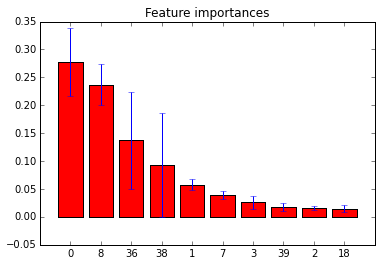

In [41]:
# plot the top ten features

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]], color="r", yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

### Adaboost Classifier

In [42]:
from sklearn.ensemble import AdaBoostClassifier

In [43]:
abc = AdaBoostClassifier(n_estimators=50, random_state=0)
abc.fit(train[features], y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=0)

In [44]:
cross_val_score(abc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean()

0.8976252032122487

In [312]:
(2602+292)*1.0/len(test)

0.8056792873051225

In [49]:
abc_prob = abc.predict_proba(test[features])

In [46]:
pd.crosstab(test['vacant'], abc.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,3093,59
1,285,131


### Single decision tree

In [299]:
from sklearn import tree

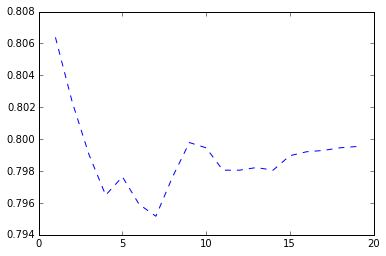

In [300]:
leafs = range(1,20,1)
scores = []
for leaf in leafs:
    clf = tree.DecisionTreeClassifier(class_weight='auto', min_samples_leaf=leaf)
    scores.append(cross_val_score(clf, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(leafs, scores, '--');

In [301]:
clf = tree.DecisionTreeClassifier(class_weight='auto', min_samples_leaf=1)
clf = clf.fit(train[features], y)

In [302]:
cross_val_score(clf, df3[features], df3.vacant, cv=10, scoring='accuracy').mean()

0.80638344724093491

In [303]:
pd.crosstab(test['vacant'], clf.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,2602,537
1,161,292


### Support Vector Machines

The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10,000 samples.

In [214]:
from sklearn import svm
kernels = ['rbf','poly','linear','sigmoid']
scores = []
for k in kernels:
    svm_mod = svm.SVC(class_weight='auto', kernel=k, random_state=0)
    scores.append(cross_val_score(svm_mod, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
print scores
svm_mod = svm.SVC(class_weight='auto', kernel='rbf', random_state=0)
svm_mod.fit(train[features], y)  

In [185]:
# linear
pd.crosstab(test['vacant'], svm_mod.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,2837,307
1,144,316


### K-nearest neighbors

In [52]:
from sklearn import preprocessing
from sklearn import neighbors

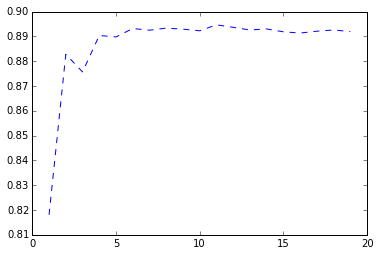

In [53]:
neighs = range(1,20)
scores = []
for n in neighs:
    knn = neighbors.KNeighborsClassifier(n_neighbors=n, weights='uniform')
    scores.append(cross_val_score(knn, (df3[features]), df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(neighs,scores,'--');

In [54]:
knn = neighbors.KNeighborsClassifier(n_neighbors=8, weights='uniform')
knn.fit(train[features], y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=8, p=2, weights='uniform')

In [55]:
pd.crosstab(test['vacant'], knn.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,3087,65
1,292,124


In [56]:
knn_prob = knn.predict_proba(test[features])

In [71]:
avg = (knn_prob+rfc_prob*2.0+abc_prob)/4.0

In [72]:
preds = avg[:,1].round()

In [73]:
pd.crosstab(test['vacant'], preds, rownames=['actual'], colnames=['preds'])

preds,0.0,1.0
actual,,
0,2950,202
1,205,211


In [74]:
(2950+211.0)/len(test)

0.8859304932735426